In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import gaussian_kde
from jax.scipy.optimize import minimize
import numpy as np
import mcmc_infinity as mc
import matplotlib.pyplot as plt
import emcee
import corner

seed = 12345

# Target Distribution

Here we try to sample a $d=2$ dimensional Rosenbrock
banana function with log-PDF given by

$$ \log f(x) = -\sum_{i=1}^{d-1} ( 100 (x_{i+1}-x_{i}^2)^2 + (1-x_{i})^2 ) + c, $$

where $c$ is an unknown normalisation constant.

In [2]:
dim = 2

target = mc.test_functions.rosenbrock.Rosenbrock(dim=dim)

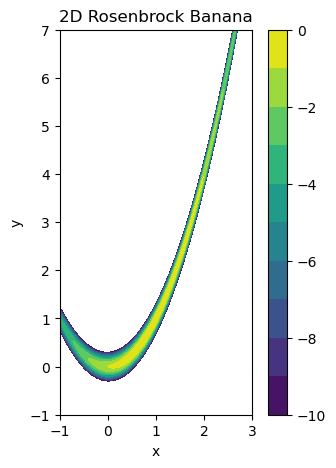

In [3]:
x = np.linspace(-1, 3, 300)
y = np.linspace(-1, 7, 300)
X, Y = np.meshgrid(x, y)
Z = target(np.stack((X,Y), axis=-1))

fig, ax = plt.subplots(figsize=(4,5))

levels = np.linspace(-10, 0, 11)
x = ax.contourf(X, Y, Z, levels=levels)
cbar = plt.colorbar(x)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("2D Rosenbrock Banana")
ax.set_aspect('equal')

plt.show()

# Proposal Distributions

We will experiment with several different proposal distributions.

 - __Uniform proposal__: We try a uniform proposal in the ranges $-1\leq x_0 \leq 3$ and $-1\leq x_1 \leq 7$.
 - __KDE proposal__: 




In [4]:
bounds = np.array([[-1.0, 3.0], [-1.0, 7.0]])

uniform_proposal = mc.uniform_proposal.UniformProposal(dim, bounds)

100%|██████████| 500/500 [00:08<00:00, 57.05it/s]

Mean acceptance fraction: 0.319
Mean autocorrelation time: 51.691


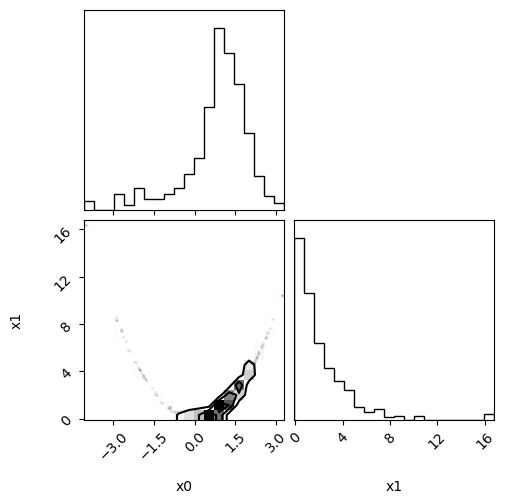

In [ ]:
# initialise emcee walker positions uniformly within prior bounds
nwalkers = 50
x0 = np.random.uniform(size=(nwalkers, dim))
x0 = bounds[:,0] + x0 * (bounds[:,1] - bounds[:,0])

# initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, dim, target)

# run burn-in
sampler.run_mcmc(x0, 100, progress=True)
sampler.reset()

# run analysis chains 
sampler.run_mcmc(x0, 5000, progress=True)
print(f"Mean acceptance fraction: {np.mean(sampler.acceptance_fraction):.3f}")
print(f"Mean autocorrelation time: {np.mean(sampler.get_autocorr_time(tol=5)):.3f}")

samples = sampler.get_chain(flat=True, thin=100)

corner.corner(samples, 
              labels=[f"x{i}" for i in range(dim)],
              ranges=[bounds[i] for i in range(dim)])

plt.show()


In [6]:
Qkde_small = mc.kde_proposal.KernelDensityEstimateProposal(dim, 
                 inflation_scale=2.0)
Qkde_small.fit(samples)

Qkde_big = mc.kde_proposal.KernelDensityEstimateProposal(dim, 
                 inflation_scale=10.0)
Qkde_big.fit(samples)

# Initialisation

The chain must be initialised at the global maximum of the function $P/Q$.

- __Uniform proposal__: For the uniform proposal this is just the peak of $P$ which we know analytically to be 
 - __KDE proposal__: For the KDE proposals we have to maximise $P/Q$ numerically.

In [17]:
sampler_uniform = mc.sampler.PerfectSampler(target, 
                                            uniform_proposal, 
                                            np.array([[1.]*dim]), 
                                            seed=seed)

sol_small = minimize(lambda x: -(target(x)-Qkde_small.logP(x)[0]), 
               jnp.ones(dim), method="BFGS", tol=1.e-2)

print(f"Solution small: {sol_small.x}, logP: {target(sol_small.x)}")

sampler_kde_small = mc.sampler.PerfectSampler(target, 
                                            Qkde_small, 
                                            jnp.atleast_2d(sol_small.x), 
                                            seed=seed)

sol_big = minimize(lambda x: -(target(x)-Qkde_big.logP(x)[0]), 
               jnp.ones(dim), method="BFGS", tol=1.e-2)

print(f"Solution big: {sol_big.x}, logP: {target(sol_big.x)}")

sampler_kde_big = mc.sampler.PerfectSampler(target, 
                                            Qkde_big, 
                                            jnp.atleast_2d(sol_big.x), 
                                            seed=seed)

Solution small: [0.96267851 0.92649159], logP: -0.0013995663622992885
Solution big: [0.99151097 0.98304019], logP: -7.235325319568416e-05


# Perfect Sampling

In [26]:
T = 4

num_samples = 10

samples_Quniform, T_Quniform = sampler_uniform.get_perfect_samples(T, num_samples, return_T=True)
samples_Qkde_small, T_Qkde_small = sampler_kde_small.get_perfect_samples(T, num_samples, return_T=True)
samples_Qkde_big, T_Qkde_big = sampler_kde_big.get_perfect_samples(T, num_samples, return_T=True)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/christophermoore/miniconda3/envs/mcmc_infinity/lib/python3.13/site-packages/jax/_src/ops/scatter.py:93: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=int32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
100%|██████████| 10/10 [00:43<00:00,  4.36s/it]


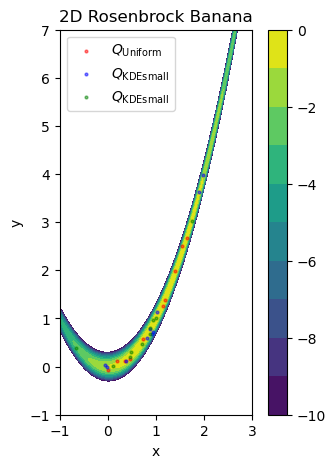

In [25]:
x = np.linspace(-1, 3, 300)
y = np.linspace(-1, 7, 300)
X, Y = np.meshgrid(x, y)
Z = target(np.stack((X,Y), axis=-1))

fig, ax = plt.subplots(figsize=(4,5))

levels = np.linspace(-10, 0, 11)
x = ax.contourf(X, Y, Z, levels=levels)
cbar = plt.colorbar(x)

ax.scatter(samples_Quniform[:, 0], samples_Quniform[:, 1],
           s=4, color='red', label=r'$Q_{\rm Uniform}$', alpha=0.5)
ax.scatter(samples_Qkde_small[:, 0], samples_Qkde_small[:, 1],
           s=4, color='blue', label=r'$Q_{\rm KDE small}$', alpha=0.5)
ax.scatter(samples_Qkde_big[:, 0], samples_Qkde_big[:, 1],
           s=4, color='green', label=r'$Q_{\rm KDE small}$', alpha=0.5)

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("2D Rosenbrock Banana")
ax.set_aspect('equal')
ax.legend(loc='upper left')

plt.show()

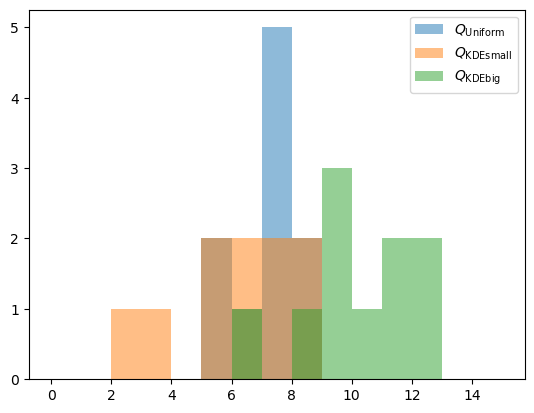

In [37]:
fig, ax = plt.subplots()

ax.hist(jnp.log2(T_Quniform), alpha=0.5, label=r'$Q_{\rm Uniform}$', bins=np.arange(0, 16))
ax.hist(jnp.log2(T_Qkde_small), alpha=0.5, label=r'$Q_{\rm KDE small}$', bins=np.arange(0, 16))
ax.hist(jnp.log2(T_Qkde_big), alpha=0.5, label=r'$Q_{\rm KDE big}$', bins=np.arange(0, 16))

ax.legend()
plt.show()